# K-Space Noise Levels

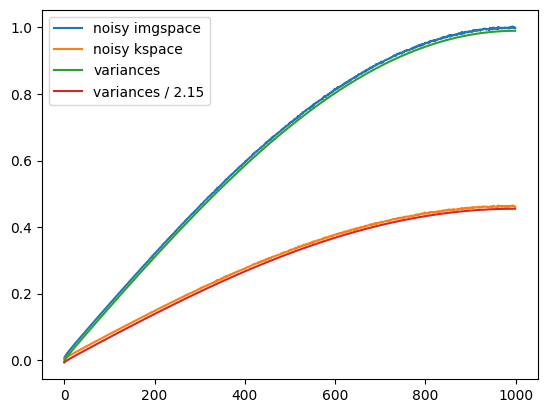

In [28]:
import sys
sys.path.append("../../diffusion_models/")
from models.diffusion import ForwardDiffusion
from sampler_dutifulpond10 import get_samples
import torch
from torch.fft import fftn, ifftn, fftshift
import matplotlib.pyplot as plt

fwd = ForwardDiffusion(timesteps=1000, type="cosine")
samples = torch.zeros((16,1,128,128))
noisies = torch.zeros_like(samples).unsqueeze(0).repeat(fwd.timesteps, 1, 1, 1, 1)
noisies_k = torch.zeros_like(noisies)
for t in range(fwd.timesteps):
    t_long = t * torch.ones((samples.shape[0]), dtype=torch.long)
    noisies[t], _ = fwd(samples, t_long)
    noisies_k[t] = torch.abs(fftshift(fftn(noisies[t], dim=(-2,-1), norm="ortho"), dim=(-2,-1)))

noisies = torch.std(noisies.squeeze(2).view(fwd.timesteps, 16, 128*128), dim=-1)
noisies = torch.mean(noisies.view(fwd.timesteps, -1), dim=-1)

noisies_k = torch.std(noisies_k.squeeze(2).view(fwd.timesteps, 16, 128*128), dim=-1)
noisies_k = torch.mean(noisies_k.view(fwd.timesteps, -1), dim=-1)

fig, ax = plt.subplots()
ax.plot(noisies, label="noisy imgspace")
ax.plot(noisies_k, label="noisy kspace")
ax.plot(fwd.sqrt_one_minus_alphas_dash - 0.01, label="variances")
ax.plot(fwd.sqrt_one_minus_alphas_dash / 2.15 - 0.01, label="variances / 2.15")
ax.legend()